In [14]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import pandas as pd
import os
from scipy.stats import norm

In [15]:
ruta_entrada= os.path.join( '.','data')
ruta_salida = os.path.join( '.','output')
ciudad = 'Valledupar'
fuente = 'IDEAM'
ruta_serie= os.path.join(ruta_entrada,ciudad,fuente+'.csv')
serie= pd.read_csv(ruta_serie, sep = ';',
                encoding='latin-1')

## Punto 1

In [42]:
def ENFICC(serie_horaria):  #Cálculo ENFICC 99%
    agnos=sorted(serie_horaria['AÑO'].unique())
    ghi_df=pd.DataFrame(columns=["AÑO","MES","DIAS","GHImes"])
    energia = list(serie_horaria)[-1]
    for agno in agnos:
        for mes in range(1,13):
            dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) &
                        (serie_horaria['MES'] == mes)]["DIA"].unique())
            ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == agno)
                            & (serie_horaria["MES"] == mes)),
                                        energia].sum()/1000
            ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1],
                        "GHImes":ghi_mes}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
        
        
    agnos2=sorted(ghi_df['AÑO'].unique())
    df_dias=pd.DataFrame(columns=["AÑO","MES","GHIdia"])
    for agno in agnos2:
        for mes in range(1,13):
            dia=ghi_df.loc[((ghi_df['AÑO']==agno) &
                                   (ghi_df['MES']==mes)),'DIAS'].item()
            ghi_diario=ghi_df.loc[((ghi_df['AÑO']==agno) & 
                                          (ghi_df['MES']==mes)),'GHImes'].item()/dia
            ghi_dict = {'AÑO':agno,'MES':mes,'GHIdia':ghi_diario}
            df_dias=df_dias.append(ghi_dict,ignore_index=True)
        
    ENFICC=df_dias.quantile(0.01,numeric_only=True)['GHIdia']
        
    return print('La ENFICC 99% es', ENFICC), df_dias

In [51]:
def graficas(serie_ideam,serie_corregida,serie_NREL):
    serie_ideam=sorted(serie_ideam["GHIdia"])
    serie_corregida=sorted(serie_corregida["GHIdia"])
    serie_NREL=sorted(serie_NREL["GHIdia"])
    x1=list(range(len(serie_ideam)))
    x2=list(range(len(serie_corregida)))
    x3=list(range(len(serie_NREL)))
    plt.plot(x1,serie_ideam/serie_ideam[-1],'r',label='IDEAM')
    plt.plot(x2,serie_corregida/serie_corregida[-1],'b',label='corregida')
    plt.plot(x3,serie_NREL/serie_NREL[-1],'g',label='NREL')
    plt.xlabel('datos')
    plt.ylabel('Energía/Energía base ideam')
    plt.legend()
    return plt.show()

## Punto 2

## Punto 3

In [17]:
corta=serie[serie['AÑO'] == 2010] #Df con todo el año 2010
seriecorta2=serie[(serie['AÑO'] >= 2007) & (serie['AÑO'] <=2012 )] #DF con año 2007 al 2011

In [18]:
ciudad = 'Valledupar'
fuente2 = 'NREL'
ruta_serie= os.path.join(ruta_entrada,ciudad,fuente2+'.csv')
serienrel= pd.read_csv(ruta_serie, sep = ';',
                encoding='latin-1')

In [19]:
def MCP(serie_corta,serie_larga):
    serie_ajustada=pd.DataFrame(columns=['AÑO','MES','DIA','HORA','GHI'])
    ghi_obj=serie_corta['IDEAM'].sum()/len(serie_corta)
    sigma_obj=serie_corta['IDEAM'].std()
    serie_larga_comun=serie_larga[(serie_larga['AÑO']>=(serie_corta.iloc[0,0])) & (serie_larga['AÑO']<=(serie_corta.iloc[-1,0]))]
    ghi_ref=serie_larga_comun['NREL'].sum()/len(serie_larga_comun)
    sigma_ref=serie_larga_comun['NREL'].std()
    for i in range(0,len(serie_larga)):
        ghi_i=((ghi_obj-(sigma_obj/sigma_ref)*ghi_ref)+(sigma_obj/sigma_ref)*serie_larga.iloc[i,4])
        if serie_larga.iloc[i,4]==0:
            ghi_i=0
            
        ano=serie_larga.iloc[i,0]
        mes=serie_larga.iloc[i,1]
        dia=serie_larga.iloc[i,2]
        hora=serie_larga.iloc[i,3]
        ghi_dict = {"AÑO":ano, "MES":mes, "DIA":dia,'HORA':hora,
                        "GHI":ghi_i}
        serie_ajustada = serie_ajustada.append(ghi_dict, ignore_index=True)
    return serie_ajustada

In [ ]:
MCP(corta,serienrel)

## Punto 4

#### MBE

In [20]:
def MBE(serie_mod,serie_obs):
    serie_mod2=serie_mod[(serie_mod['AÑO'] >=serie_obs.iloc[0,0])]
    error=0
    sumatoria=0
    for i in range(0,len(serie_obs)):
        resta=serie_obs.iloc[i,4]-serie_mod2.iloc[i,4]
        error=error+resta
        sumatoria=sumatoria+serie_obs.iloc[i,4]
    resultado=error/sumatoria
    return print('El MBE es:',"{:.2%}".format(resultado) )

#### RMSE

In [26]:
def RMSE(serie_mod,serie_obs):
    serie_mod2=serie_mod[(serie_mod['AÑO'] >=serie_obs.iloc[0,0]) &(serie_mod['AÑO']<=serie_obs.iloc[-1,0])]
    error=0
    for i in range(0,len(serie_obs)):
        resta=(serie_obs.iloc[i,4]-serie_mod2.iloc[i,4])**2
        error=error+resta
    error=sqrt(error/len(serie_obs))
    resultado=error/(serie_obs['IDEAM'][serie_obs['IDEAM'].idxmax()]-serie_obs['IDEAM'][serie_obs['IDEAM'].idxmin()])
    return print('El RMSE es:',"{:.2%}".format(resultado) )

#### KSI

In [38]:
def KSI(serie_mod,serie_obs):
    serie_mod2=serie_mod[(serie_mod['AÑO'] >=serie_obs.iloc[0,0]) &(serie_mod['AÑO']<=serie_obs.iloc[-1,0])]
    error=sp.stats.ks_2samp(serie_mod2['IDEAM'],serie_obs['NREL'])
    return print('El pvalue es:',error[-1])

In [39]:
KSI(serie,serienrel)

El pvalue es: 1.29836256126e-61


In [41]:
ENFICC(serie)

La ENFICC 99% es 4.56900737661


(None,         AÑO   MES    GHIdia
 0    2006.0   1.0  5.426402
 1    2006.0   2.0  6.049858
 2    2006.0   3.0  5.602049
 3    2006.0   4.0  5.352159
 4    2006.0   5.0  5.604888
 5    2006.0   6.0  5.602158
 6    2006.0   7.0  5.362423
 7    2006.0   8.0  5.683691
 8    2006.0   9.0  5.211831
 9    2006.0  10.0  5.119954
 10   2006.0  11.0  5.250348
 11   2006.0  12.0  5.433051
 12   2007.0   1.0  5.574657
 13   2007.0   2.0  6.019441
 14   2007.0   3.0  5.539717
 15   2007.0   4.0  5.691355
 16   2007.0   5.0  4.936006
 17   2007.0   6.0  5.949760
 18   2007.0   7.0  5.730243
 19   2007.0   8.0  5.225471
 20   2007.0   9.0  5.076315
 21   2007.0  10.0  4.804463
 22   2007.0  11.0  5.014997
 23   2007.0  12.0  5.423405
 24   2008.0   1.0  5.726034
 25   2008.0   2.0  5.824592
 26   2008.0   3.0  5.473850
 27   2008.0   4.0  5.683294
 28   2008.0   5.0  5.412217
 29   2008.0   6.0  5.546663
 ..      ...   ...       ...
 90   2013.0   7.0  5.633788
 91   2013.0   8.0  5.068445
 92   20

In [49]:
serie1=ENFICC(serie)[-1]
serie2=ENFICC(serie)[-1]
serie3=ENFICC(serienrel)[-1]

La ENFICC 99% es 4.56900737661
La ENFICC 99% es 4.56900737661
La ENFICC 99% es 5.06265316667


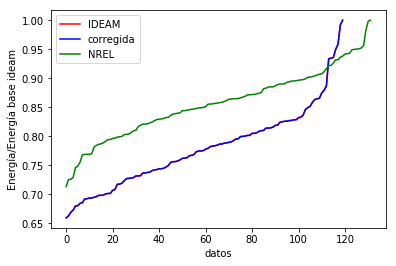

In [52]:
graficas(serie1,serie2,serie3)